# Create Data Vector

To validate and test the y3 cluster pipeline we make a simplified mock data of the Buzzard v.1.9.8 dataset. Here I build the data vector.

Outline:
- Number counts
- Binned $\gamma_t(\theta)$ profiles
- Power Spectrum (using nbody-tool kit)


In [1]:
#!/usr/bin/env python
import os

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table
from scipy.interpolate import interp1d

In [2]:
# !pip3 install fitsio

In [3]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [4]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
const = 1.67e-7 * (0.3 * 0.7**2) # /Mpc^2
rhom = const/6.01e-19  # Msun/Mpc^2

cosmo0 

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [5]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$'}


## Load Mock

For this first validation we will use $\lambda>5$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

In [6]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [7]:
data = Table(getdata(floc.mock_fname))
print('All data size: %i'%(len(data)))

All data size: 583043


In [8]:
lgt5 = np.array(data['lambda_mor'])>=5.
lgt20 = np.array(data['lambda_mor'])>=20.

mock = data[lgt5]

print(r'$\lambda>5$ has size: %i'%np.count_nonzero(lgt5))
print(r'$\lambda>20$ has size: %i'%np.count_nonzero(lgt20))

$\lambda>5$ has size: 263129
$\lambda>20$ has size: 11092


In [9]:
# some other quantities
ra, dec = np.array(mock['RA']), np.array(mock['DEC'])
lbd = np.array(mock['lambda_mor'])
z = np.array(mock['redshift'])


In [10]:
dictCov = dict()
dictData = dict()

# Number Counts

We will try to use the same bining scheme from DES Y1.

$$
\lambda \in [5, 20, 30, 45, 60, \infty] \\
z \in [0.2, 0.35, 0.5, 0.65]
$$

However in the Buzzard simulations the overall number of cluster is less than the DES Y3. So, we might need to change the binning scheme in order to have a reasonable statistics.

In [11]:
from setup_bins import lbdbins, zmin_list, zmax_list, zmeans, lbdmeans

print('lambda bins:', lbdmeans)
print('redshift bins:', zmeans)

lambda bins: [ 7.5 12.  17.  25.  37.5 52.5 95. ]
redshift bins: [0.25  0.44  0.575]


In [12]:
zlabels = ['%.2f < z < %.2f'%(zl,zh) for zl, zh in zip(zmin_list, zmax_list)]
zlabels

['0.20 < z < 0.32', '0.37 < z < 0.51', '0.51 < z < 0.64']

In [13]:
kw = {'dS':r'$\Delta \Sigma \, \, [M_{\odot}]$',
      'gamma': r'$\left< \gamma_t(\theta) \right>$',
      'physical':r'$\rm R_p\ [Mpc]$',
      'angle': r'$\theta \; [arcmin]$'
     }

In [14]:
def compute_number_counts(x, z, xbins):
    counts = []
    for xl, xh in zip(xbins[:-1], xbins[1:]):
        xmask = (x>=xl)&(x<=xh)
        xcounts = []
        for zl, zh in zip(zmin_list, zmax_list):
            zmask = (z>=zl)&(z<=zh)
            xcounts.append(np.count_nonzero(zmask&xmask))
        counts.append(xcounts)
    return np.array(counts)

In [15]:

nc_all_binY3 = compute_number_counts(lbd, z, lbdbins)

In [16]:
print(nc_all_binY3)

[[30284 69525 87600]
 [ 6076 12841 15447]
 [ 3193  6590  7431]
 [ 1550  2982  3084]
 [  512   918   883]
 [  133   183   152]
 [   55    67    41]]


In [17]:
np.sqrt(10)

3.1622776601683795

In [18]:
lb60 = (lbd<lbdbins[-1])&(lbd>=lbdbins[-2])

(array([ 1.,  2.,  9., 30., 45., 35., 24., 10.,  8.,  4.]),
 array([14.455911, 14.534698, 14.613485, 14.692272, 14.771059, 14.849846,
        14.928634, 15.007421, 15.086207, 15.164995, 15.243782],
       dtype=float32),
 <BarContainer object of 10 artists>)

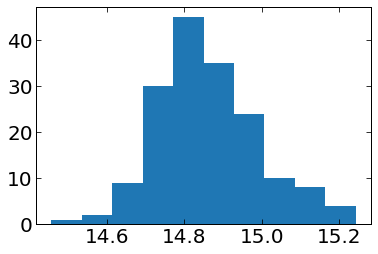

In [19]:
plt.hist(np.log10(mock['Mvir'][lb60]))

(10, 208632.0622082377)

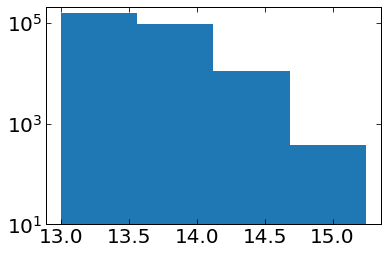

In [20]:
mbins = np.linspace(np.min(np.log10(mock['Mvir'])), np.max(np.log10(mock['Mvir'])), 5)
plt.hist(np.log10(mock['Mvir']),bins=mbins)
plt.yscale('log')
plt.ylim(10)

mean, p5, p95: 6.22, 5.08, 8.42
mean, p5, p95: 10.65, 6.96, 17.82
mean, p5, p95: 25.17, 16.90, 41.52
mean, p5, p95: 59.44, 42.88, 93.68


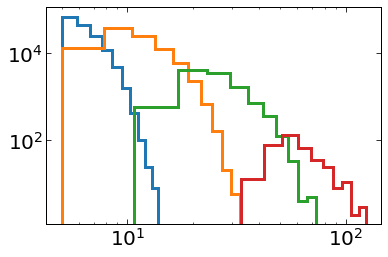

In [21]:
def get_mask(x,xl,xh):
    mask = (x>=xl)&(x<=xh)
    return np.where(mask)[0]

def show_log_stats(x):
    log_x = np.log10(x)
    p5, p95 = list(np.percentile(x, [5,95]))
    print('mean, p5, p95: %.2f, %.2f, %.2f'%(10**np.mean(log_x),p5,p95))
        

mvir = np.log10(np.array(mock['Mvir']))
keys = [get_mask(mvir,ml,mh) for ml, mh in zip(mbins[:-1],mbins[1:])]

plt.loglog()
for ix in keys:
    plt.hist(lbd[ix],histtype='step',lw=3)
    show_log_stats(lbd[ix])

The number of clusters on the last lambda bins are very low, specially for the highest one. We should re-define the lambda bins

In [22]:
# lbdbins_new = np.array([5, 15, 25, 40, 160])
lbdbins_new = np.array([5, 10, 14, 35, 130])
print('lambda bins:', lbdbins_new)

lambda bins: [  5  10  14  35 130]


(90, 250644.50759751472)

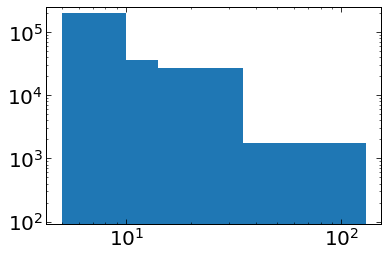

In [23]:
plt.loglog()
plt.hist(lbd, bins=lbdbins_new)
plt.ylim(90,)

In [24]:
np.logspace(np.log10(5), np.log10(130), 5)

array([  5.        ,  11.29050432,  25.49509757,  57.57050185,
       130.        ])

In [25]:
# lbd = np.array(mock['lambda_mor'])
# z = np.array(mock['redshift'])

nc_all_new = compute_number_counts(lbd, z, lbdbins_new)
print(nc_all_new)

[[30284 69525 87600]
 [ 6076 12841 15447]
 [ 5000 10091 11024]
 [  443   649   567]]


Now we have at least 100 clusters on the highest lambda bins

In [26]:
100/np.sqrt(nc_all_new.flatten())

array([0.57463673, 0.37925342, 0.33786869, 1.28289501, 0.88247127,
       0.80459611, 1.41421356, 0.99548082, 0.95242415, 4.75114338,
       3.92534336, 4.19960526])

In [27]:
lam_labels = ['%i < $\lambda $ < %i'%(ll,lh) for ll, lh in zip(lbdbins_new[:-1], lbdbins_new[1:])]
lam_labels

['5 < $\\lambda $ < 10',
 '10 < $\\lambda $ < 14',
 '14 < $\\lambda $ < 35',
 '35 < $\\lambda $ < 130']

In [28]:
dictData['NC'] = nc_all_new.flatten()
dictCov['NC'] = np.diag(np.sqrt(nc_all_new.flatten()))

# $\gamma_t(\theta)$ Profiles

In this section we will convert the physical quantities of the $\Delta \Sigma (R)$ profiles in observed $\gamma_t(\theta)$ profiles. 

The conversion happens in three steps:
- The conversion factor between matter excess and the observed shear profile is $\Sigma^{\prime}_{\rm crit} (z)$.
- The second step is to convert physical units to angular units
- Lastly, we stack the profiles in lambda and redshift bins.

### Boost-Factor 
In this idealized test we don't model Boost-Factor contamination. We will add the model in the next steps of the pipeline.

In [29]:
import radial_bins_phys_mpc as rbp

radii = rbp.rp_phys_mpc
theta = rbp.theta_arcmin

deltaSigma = np.array(mock['DeltaSigma'])
redshift = np.array(mock['redshift'])
lnM = np.log(np.array(mock['Mvir']))
print('Delta Sigma shape:',deltaSigma.shape)

Delta Sigma shape: (263129, 15)


In [30]:
bTable = np.load(floc.mock_boost_factor_1d)
print(list(bTable.keys()))

betaEff = bTable['betaEff']
zEff = bTable['zEff']
zlens = bTable['zlens']


['betaEff', 'zEff', 'zlens', 'Radii']


In [31]:
# G=4.51710305e-48 # Mpc^3 / M_sol / s^2
# c=9.71561189e-15 # Mpc/s

# 4piG/c^2
const = 6.01e-19 # Mpc/M_sol
const*= 1e6 # pc/M_sol

dlens = cosmo0.comoving_distance(zlens).value*1e6 # pc
sigma_crit_vec = const*dlens[:,np.newaxis]*betaEff
sigma_crit_vec_z = sigma_crit_vec[:,-1]

Text(0.5, 1.0, 'Critical Density Amplitude')

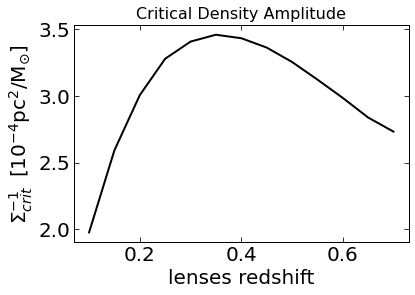

In [32]:
# sigma_crit vs z_lens
plt.plot(zlens, sigma_crit_vec_z*1e4, lw=2, color='k')
plt.xlabel('lenses redshift')
plt.ylabel(r'$\Sigma^{-1}_{crit} \; \; [10^{-4} \rm pc^2/M_{\odot}$]')
plt.title('Critical Density Amplitude',fontsize=16)

### Plot Shear

In [33]:
sigma_crit = np.interp(redshift, zlens, sigma_crit_vec_z)
shear = deltaSigma*sigma_crit[:,np.newaxis]

Text(0.5, 0.98, 'Individual Profiles - Random Draw')

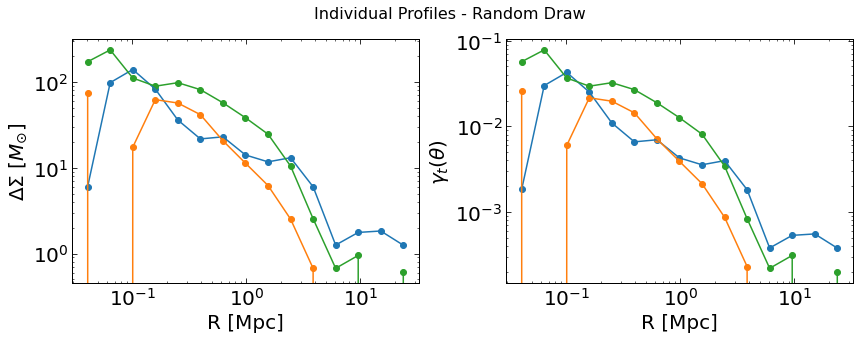

In [34]:
np.random.seed(42)

plt.figure(figsize=(14,4.5))
plt.subplot(1,2,1)
plt.loglog()
randoms = []
for i in range(3):
    ix = np.random.randint(shear.shape[0])
    plt.scatter(radii, deltaSigma[ix])
    plt.plot(radii, deltaSigma[ix])
    randoms.append(ix)
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

plt.subplot(1,2,2)
plt.loglog()
for i in range(3):
    ix = randoms[i]
    plt.scatter(radii, shear[ix])
    plt.plot(radii, shear[ix])
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\gamma_t(\theta) $')

plt.subplots_adjust(wspace=0.25)
plt.suptitle('Individual Profiles - Random Draw', fontsize=16)


# Stacking Profiles


In [35]:
import stacked_profile_weighted_by_mass_redshift as spw

class StackingProfiles(object):
    def __init__(self, lam_bins, z_min, z_max, method='weighted'):
        #print('Stacking Profiles Algorithm')
        self.lam_bins = lam_bins
        #self.z_bins = z_bins
        self.z_min = z_min
        self.z_max = z_max
        self.method = method
        self.nl = lam_bins.size-1
        self.nz = z_min.size
    
    def load_profiles(self, z, lnM, lam, profile):
        self.z_all = z
        self.alt_rich = lam
        self.lnMvir_all = lnM
        self.profile_all = profile
    
    def run_all_bins(self):
        stack_bins = []
        mean_bins = []
        for lam_min, lam_max in zip(self.lam_bins[:-1], self.lam_bins[1:]):
            #print(5*'----')
            #print('lam_min, lam_max = %i, %i'%(lam_min, lam_max))
            r1, r2 = [], []
            for zmin, zmax in zip(self.z_min, self.z_max):
                #print('zmin, zmax = %.2f, %.2f'%(zmin, zmax))
                # take mean values in a bin weighting by mass and redshift
                prof_sel_mean, prof_sel_stacked = self.stacking_profiles(zmin, zmax,
                                                 lam_min, lam_max)
                r1.append(prof_sel_mean)
                r2.append(prof_sel_stacked)                  

            mean_bins.append(r1)
            stack_bins.append(r2)
        return np.array(mean_bins), np.array(stack_bins)
            
    def stacking_profiles(self, zmin, zmax, lam_min, lam_max, dm = 0.1, dz = 0.05):

        select_obs = (self.alt_rich > lam_min)&(self.alt_rich < lam_max)&(self.z_all>=zmin)&(self.z_all<zmax)

        lnMvir_select = self.lnMvir_all[select_obs]
        z_select = self.z_all[select_obs]
        Sigma_select = self.profile_all[select_obs,:]
        Sigma_select_mean = np.mean(Sigma_select, axis=0)

        if self.method == 'weighted':
            Sigma_stacked = spw.stacked_profile_weighted_by_mass_redshift(lnMvir_select, z_select, Sigma_select, self.lnMvir_all, self.z_all, self.profile_all, dm=dm, dz=dz)

        return Sigma_select_mean, Sigma_stacked

In [36]:
sp = StackingProfiles(lbdbins_new, zmin_list, zmax_list, method='weighted')
sp.load_profiles(redshift, lnM, lbd, deltaSigma)
print('Delta Sigm')
dS_mean, dS_stack = sp.run_all_bins()
print()
print('Starting Shear Stacking')
sp.load_profiles(redshift, lnM, lbd, shear)
gt_mean, gt_stack = sp.run_all_bins()

Delta Sigm

Starting Shear Stacking


In [37]:
def plot_profile(x,px,ax=None,xcol='physical',**kwargs):
    if ax is None: ax = plt.gca()
    ax.loglog()
    ax.plot(x,px,**kwargs)
    ax.set_xlabel(kw[xcol])

Text(0.5, 0.98, 'Stacked Profiles in Physical Units')

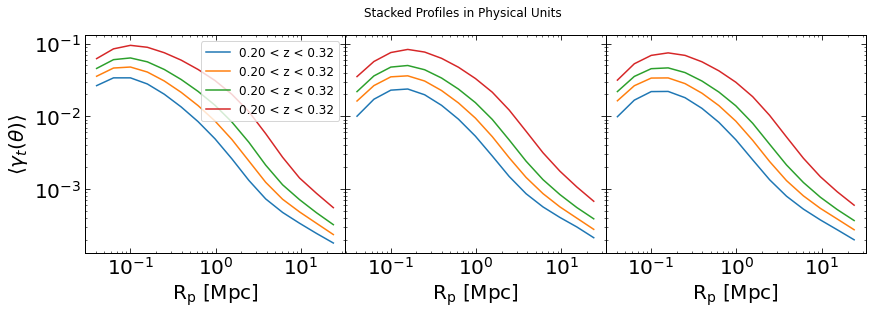

In [38]:
fig, axes = plt.subplots(1, sp.nz, sharex=True, sharey=True, figsize=(sp.nz*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nz):
        ax = axes[i]
        label = None
        for j in range(sp.nl):
            if i==0: label=zlabels[i]
            plot_profile(radii,gt_stack[j][i],ax=ax,label=label)

axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=1)
fig.suptitle('Stacked Profiles in Physical Units')

## Convert from Physical Units to Angle 

We will use arcmin for instance.

In [80]:
from scipy.interpolate import interp1d

# angular conversion factor
rad2deg = 180/np.pi
conv_factor = {"radians": 1.,
               "degrees": 1.*rad2deg, 
               "arcmin" : 60.*rad2deg, 
               "arcsec" : 360.*rad2deg}

# angular distance interpolator
zvec = np.linspace(0., 1.5, 100)
da_interp = interp1d(zvec, cosmo0.angular_diameter_distance(zvec).value)

def theta_converter(r,z):
    # radii or z needs to be a float number 
    theta_vec = r/da_interp(z)
    return theta_vec*conv_factor["arcmin"]

def convert_profile(z, profile, rbin=radii, tbin=theta):
    theta_vec = theta_converter(rbin, z)
    interp_gamma_t = interp1d(theta_vec, profile, bounds_error=False)(tbin)
    return interp_gamma_t

In [40]:
gt_mean_theta, gt_stack_theta = [], []
for i in range(sp.nl):
    r1, r2 = [], []
    for j in range(sp.nz):
        zi = zmeans[j]
        gt_t = convert_profile( zi , gt_stack[i][j])
        r1.append(gt_t)
    gt_stack_theta.append(r1)

Text(0.5, 0.98, 'Stacked Profiles in Angle Units')

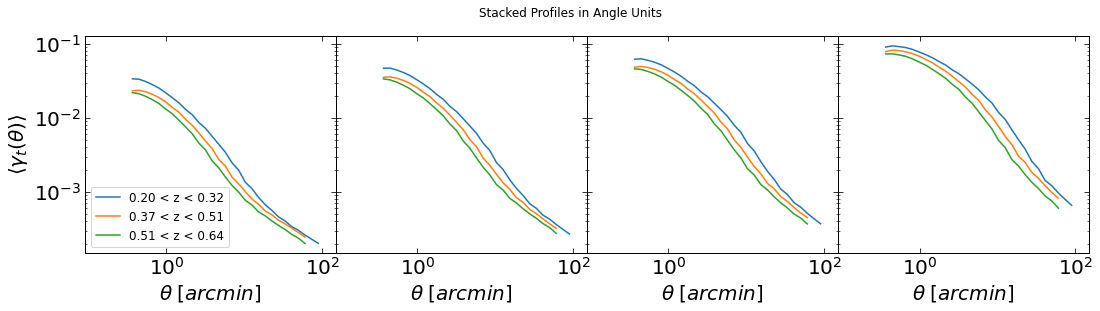

In [41]:
fig, axes = plt.subplots(1, sp.nl, sharex=True, sharey=True, figsize=(sp.nl*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nl):
        ax = axes[i]
        label = None
        for j in range(sp.nz):
            if i==0: label=zlabels[j]
            plot_profile(theta, gt_stack_theta[i][j],ax=ax,xcol='angle',label=label)

axes[0].set_xlim(9e-2, 1.5e2)
axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=3)
fig.suptitle('Stacked Profiles in Angle Units')

Text(0.5, 0.98, 'Stacked Profiles in Physical Units')

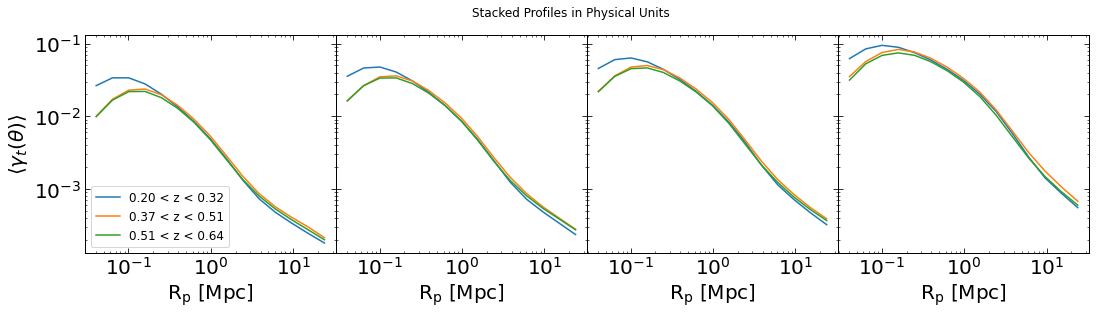

In [42]:
fig, axes = plt.subplots(1, sp.nl, sharex=True, sharey=True, figsize=(sp.nl*4+2, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for i in range(sp.nl):
        ax = axes[i]
        label = None
        for j in range(sp.nz):
            if i==0: label=zlabels[j]
            plot_profile(radii, gt_stack[i][j],ax=ax,label=label)

# axes[0].set_xlim(9e-2, 1.5e2)
axes[0].set_ylabel(kw['gamma'])
axes[0].legend(fontsize=12,loc=3)
fig.suptitle('Stacked Profiles in Physical Units')

### Ilustrating the difference

In [43]:
# we should pay attention to the redshift edges
theta_converter(radii, 0.2)

array([  0.20492402,   0.32318717,   0.50970085,   0.80385294,
         1.26776236,   1.9993973 ,   3.15326413,   4.97303596,
         7.84301143,  12.36927078,  19.50766755,  30.76568539,
        48.52078778,  76.52248982, 120.68417921])

In [44]:
theta_converter(radii, 0.65)

array([ 0.09757297,  0.15388305,  0.24269008,  0.3827483 ,  0.60363515,
        0.95199742,  1.5014021 ,  2.36787224,  3.73438866,  5.88953171,
        9.2884236 , 14.6488409 , 23.10279428, 36.43558609, 57.46282971])

In [45]:
mask = mock['M200']>7e14
randoms = [np.argmin(redshift[mask]), np.argmax(redshift[mask])]

Text(0.5, 0.98, 'Angle Distance Effect - Same Clusters')

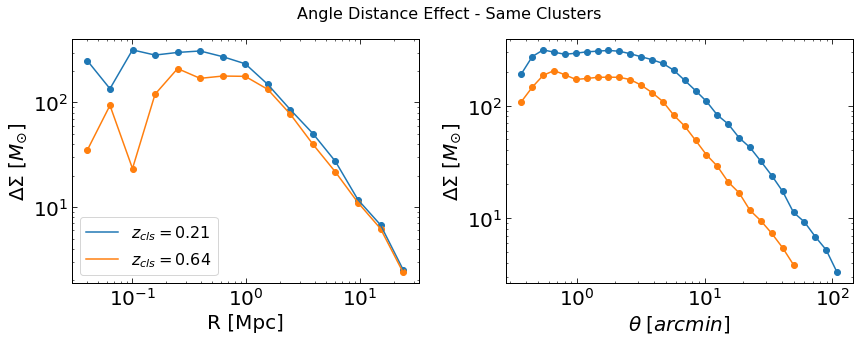

In [46]:
np.random.seed(42)

plt.figure(figsize=(14,4.5))
plt.subplot(1,2,1)
plt.loglog()
for ix in randoms:
    zcls = redshift[mask][ix]
    plt.scatter(radii, deltaSigma[mask][ix])
    plt.plot(radii, deltaSigma[mask][ix],label=r'$z_{cls} = %.2f$'%(zcls))
    
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')
plt.legend(fontsize=16)
plt.subplot(1,2,2)
plt.loglog()
for ix in randoms:
    zcls = redshift[mask][ix]
    ds = convert_profile(zcls, deltaSigma[mask][ix]) 
    plt.scatter(theta, ds)
    plt.plot(theta, ds,label=r'$z_{cls} = %.2f$'%(zcls))


plt.xlabel(r'$\theta \; [arcmin]$')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

plt.subplots_adjust(wspace=0.25)
plt.suptitle(r'Angle Distance Effect - Same Clusters', fontsize=16)


# Covariance

There are three main different ways of estimating the covariance matrix. From the real or simulated data usually use the variance over a range of sub samples. From the theory is a method that don't carry the noise introduced by the data based estimators.

## Number Counts

For the number counts, we can apply a bootstrap techinique. For simplicity, we will use only the poisson error $\sqrt{N}$.

In [47]:
# covariance only on the diagonals
# no covariance between lambda and redshift bins
cov = np.sqrt(nc_all_binY3.flatten())**2

# wich is equal to the number counts vector

## Shear

For the shear we actually have enough stats to perform a JK covariance across radial bins.

In [48]:
import treecorr
n_patches = 50
c1 = treecorr.Catalog(ra=ra, dec=dec, npatch=n_patches, ra_units='degrees', dec_units='degrees')
labels = c1.patch


In [49]:
labels

array([10, 10,  7, ..., 33, 34, 34])

In [50]:
# uses treecorr to find the groups
k_stack = []
for k in range(n_patches):
    idx = (labels != k ) # leave the group k
    sp = StackingProfiles(lbdbins, zmin_list, zmax_list, method='weighted')
    sp.load_profiles(redshift[idx], lnM[idx], lbd[idx], shear[idx])
    k_stack.append(sp)

In [71]:
from joblib import delayed, Parallel

def get_shear_stack(self):
    gt_mean, gt_stack = self.run_all_bins()
    return gt_stack

nCores = 64
# _shear_jk = Parallel(n_jobs=nCores)(delayed(get_shear_stack)(k_stack[k]) for k in range(n_patches))

In [ ]:
shear_jk = np.array(_shear_jk)
shear_jk.shape

In [ ]:
def get_jk_cov(jk_stats,npatches):
    """
    Get JackKnife covariance and error bar. 
 
    Args:
        jk_stats (array): array with the statistics computed for each JK patch
        npatches (float): number of JK patches 
    """
    mean  = np.mean(jk_stats, axis =0)
    cov_jk  = np.sum((jk_stats - mean[None, :])[:, :, None] *
                 (jk_stats - mean[None, :])[:, None, :], axis=0)
    cov_jk *= ((npatches - 1.)/npatches)  
    sig_jk  = np.sqrt(np.diag(cov_jk))
    return cov_jk, sig_jk, mean

In [ ]:
# block diagonals
nl = 3
nz = 4
nr = 15

covariances = []
sigmas = []
means = []

covs = np.zeros((nz*nr, nl*nr))
coefs = covs
for i in range(nz):
    ilow, imax = i*nr, (i+1)*nr
    for j in range(nl):
        jlow, jmax = j*nr, j*nr + nr
        cov, sig, mean = get_jk_cov(shear_jk[:,i,j,:], n_patches)
        covs[ilow:imax, jlow:jmax] = cov
        coefs[ilow:imax, jlow:jmax] = np.corrcoef(cov)
        covariances.append(cov)
        sigmas.append(sig)
        means.append(mean)

In [ ]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage.filters import gaussian_filter

cmap = 'plasma'
vmin, vmax = 0.01, 1.
plt.figure(figsize=(10,10))
img = plt.imshow(gaussian_filter(coefs, 0.15), origin='lower', norm=PowerNorm(gamma=4, vmin=vmin, vmax=vmax), cmap=cmap)

for i in range(nz):
    plt.axhline(i*nr, color='w', lw=3)

for i in range(nl):
    plt.axvline(i*nr, color='w', lw=3)

plt.colorbar(img, shrink=0.6)
plt.title('Covariance: ' + kw['gamma'] )

In [ ]:
plt.loglog()
for i in range(4):
    plt.plot(radii, sigmas[i]/means[i])

In [ ]:
from scipy import linalg

shear_cov = linalg.block_diag(*covariances)

In [ ]:
dictData['Shear'] = np.stack(gt_stack_theta).flatten()
dictCov['Shear'] = linalg.block_diag(*covariances)

# 2pt Angular Correlation Function: $w_p(\theta)$

Here I plot the results and the covariance.

In [54]:
# lbdbins =  np.array([5, 10, 14, 20, 30, 45, 60, 130])
lbdbins = np.array([5, 10, 14, 35, 130])
lbdmeans = 0.5*(lbdbins[1:]+lbdbins[:-1])
lbdmeans_ij = np.repeat(lbdmeans, 3)

## mock
zbins = np.array([0.2, 0.32, 0.373, 0.51, 0.65])
zmin_list = np.array([0.2, 0.373, 0.51])
zmax_list = np.array([0.32, 0.51, 0.64])
zmeans = np.array([0.25, 0.44, 0.575])

In [55]:
# Setup file loc
from fileLoc import FileLocs
floc = FileLocs(machine='nersc')
path = floc.halo_run_loc
indir = path+'/wp/input/'
outdir = path+'/wp/output/'

# fname_base = indir+'mock_%s_box%i.fits'
fname_out = outdir+'mock_%s_3d_box%03d.npz'

In [56]:
nz = zmeans.size
nl = lbdmeans.size
nij = nz*nl

def look_up(l,z):
    il = np.argmin(np.abs(lbdmeans-l))
    iz = np.argmin(np.abs(zmeans-z))
    
    # for the case with no lambda bining
    il = np.where(l>300, nl, il)
    
    ij = nz*il + iz
    return ij

def load_files(npatches):    
    out = []
    for ij in range(nij+nz):
        file = fname_out%('kmeans%i'%npatches, ij)
        out.append(np.load(file))
    return out

In [94]:
npatches = 20
vecs = load_files(npatches)

theta_wp = np.logspace(np.log10(20), np.log10(120), 6)

In [95]:
wpij = vecs[look_up(lbdmeans[0], zmeans[0])]
wpij_t = convert_profile( zmeans[0] , wpij['mean'], rbin=wpij['r'], tbin=theta_wp)


In [98]:
wpij['mean']

array([4.40818316, 2.63180192, 1.54099762, 0.81393377, 0.46114943,
       0.24242197])

In [97]:
wpij_t

array([       nan, 3.82054764, 2.16573901, 1.15729191, 0.59337917,
       0.30145745])

In [ ]:
gt_mean_theta, gt_stack_theta = [], []
for i in range(sp.nl):
    r1, r2 = [], []
    for j in range(sp.nz):
        zi = zmeans[j]
        gt_t = convert_profile( zi , gt_stack[i][j])
        r1.append(gt_t)
    gt_stack_theta.append(r1)

In [59]:
def get_label(vec):
    if 'nobj' in list(vec.keys()):
        return 'Nsize: %i'%vec['nobj']
    else:
        return None
    
def plot_profile(vecs, l, z, ax=None):
    if ax is None: ax = plt.gca()
    vec = vecs[look_up(l,z)]
    r, xi = vec['r'], vec['mean']
    sig = vec['sig']
    cov = vec['cov']
    
    #label = get_label(vec)
    NRbin = r.size
    try:
        SNR = (np.matmul(np.matmul(xi,np.linalg.inv(cov)),xi.T)-NRbin)**0.5
    except:
        print(r'Error singular matrix: $\lambda, z = %.2f, %.2f$'%(l,z))
        SNR = -1
        
    label = 'SNR=%.1f'%SNR
    # print('SNR =',SNR)

    #ax.loglog()
    #ax.set_xscale('log')
    ax.scatter(r, xi, s=50)
    ax.errorbar(r, xi, yerr=sig, lw=3, ls='', label=label)
    
def plot_sigma(vecs, l, z, ax=None):
    if ax is None: ax = plt.gca()
    vec = vecs[look_up(l,z)]
    r, xi = vec['r'], vec['mean']
    sig = vec['sig']
    cov = vec['cov']
    NRbin = r.size
    try:
        SNR = (np.matmul(np.matmul(xi,np.linalg.inv(cov)),xi.T)-NRbin)**0.5
    except:
        SNR = -1
        print(r'Error singular matrix: $\lambda, z = %.2f, %.2f$'%(l,z))
        
        
    print('SNR =',SNR)
    label = get_label(vec)
    label+= '\n SNR=%.1f'%SNR
    ax.plot(r, sig/xi)
    ax.scatter(r, sig/xi, s=50, label=label)

Text(0, 0.5, '$w_p(R_p)$')

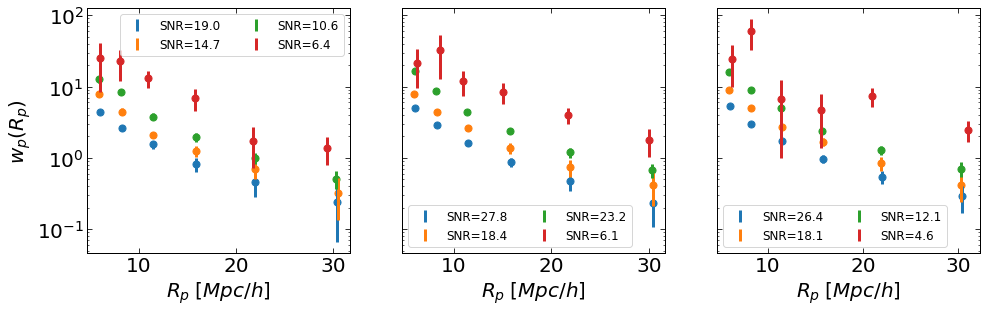

In [60]:
fig, axs = plt.subplots(1,3,figsize=(16,4.5),sharey='all')

for j in range(3):
    ax = axs[j]
    ax.set_yscale('log')
    # ax.set_xscale('log')
    for i in range(nl):
        #plt.xlabel('R [Mpc/h]')
        plot_profile(vecs, lbdmeans[i], zmeans[j], ax=ax)
        # plt.title('zmean: %.3f'%zmeans[i])
        ax.set_xlabel(r'$R_{p} \; [Mpc/h]$')
        # plt.xlim(2.0, )
        # plt.legend(fontsize=12)
    ax.legend(fontsize=12, ncol=2)
axs[0].set_ylabel(r'$w_p(R_p)$')
# ax.set_ylim(0.03, 200)

Text(0, 0.5, '$w_p(\\theta)$')

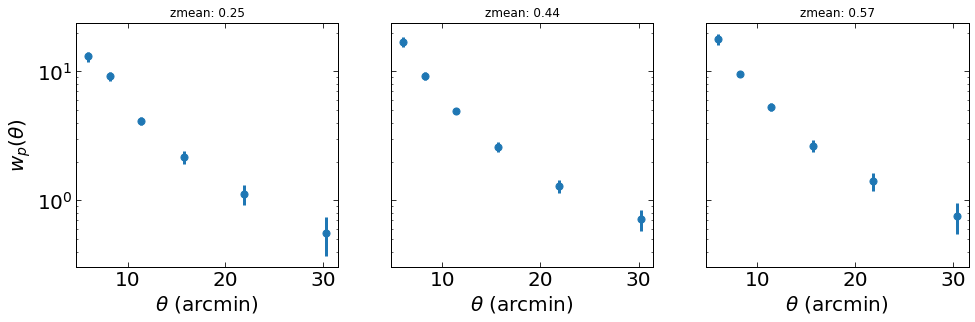

In [61]:
fig, axs = plt.subplots(1,3,figsize=(16,4.5),sharey='all')
for j in range(3):
    ax = axs[j]
    ax.set_yscale('log')
    #for i in range(4):
    #plt.xlabel('R [Mpc/h]')
    plot_profile(vecs, 1000, zmeans[j], ax=ax)
    ax.set_title('zmean: %.2f'%zmeans[j])
    ax.set_xlabel(r'$\theta$ (arcmin)')
    # plt.xlim(2.0, )
    # plt.legend(fontsize=12)
axs[0].set_ylabel(r'$w_p(\theta)$')
# ax.set_ylim(0.003, 1)

SNR = 17.26717387465838
SNR = 20.055120860007307
SNR = 21.40206874104638


Text(0, 0.5, '$\\sigma_{\\rm JK}(w_p)/w_p$')

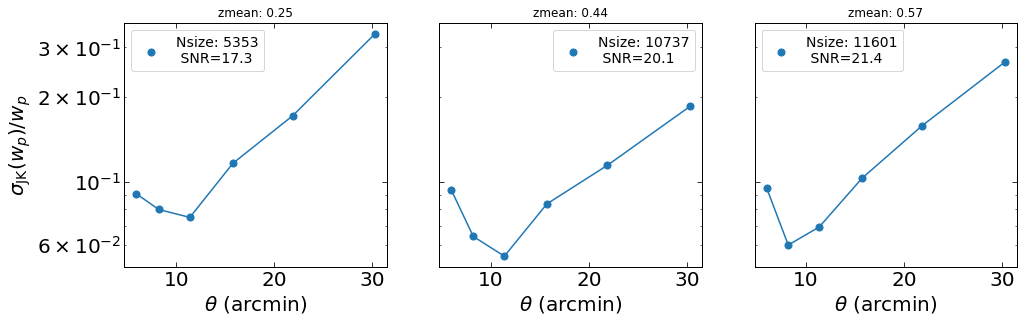

In [62]:
fig, axs = plt.subplots(1,3,figsize=(16,4.5),sharey='all')
for j in range(3):
    ax = axs[j]
    ax.set_yscale('log')
    #for i in range(4):
    #plt.xlabel('R [Mpc/h]')
    plot_sigma(vecs, 1000, zmeans[j], ax=ax)
    ax.set_title('zmean: %.2f'%zmeans[j])
    ax.set_xlabel(r'$\theta$ (arcmin)')
    # plt.xlim(2.0, )
    # plt.legend(fontsize=12)
    ax.legend(fontsize=14)
axs[0].set_ylabel(r'$\sigma_{\rm JK}(w_p)/w_p$')
# ax.set_ylim(0.03, 1)

In [101]:
# block diagonals
nl = 4
nz = 3
nr = vecs[0]['r'].size

covariances, means, sigmas = [], [], []

covs = np.zeros((nz*nr, nl*nr))
coefs = covs
for j in range(nl):
    jlow, jmax = j*nr, j*nr + nr
    for i in range(nz):
        ilow, imax = i*nr, (i+1)*nr
        cov = vecs[look_up(lbdmeans[j], zmeans[i])]['cov']
        mean = vecs[look_up(lbdmeans[j], zmeans[i])]['mean']
        covs[ilow:imax, jlow:jmax] = cov
        coefs[ilow:imax, jlow:jmax] = np.corrcoef(cov)
        covariances.append(cov)
        #sigmas.append(sig)
        means.append(mean)

In [102]:
cmap = 'plasma'
vmin, vmax = 0.01, 1.
plt.figure(figsize=(10,10))

img = plt.imshow(gaussian_filter(coefs, 0.5), origin='lower', norm=PowerNorm(gamma=1., vmin=vmin, vmax=vmax), cmap=cmap)

for i in range(nz):
    plt.axhline(i*nr, color='w', lw=3)

for i in range(nl):
    plt.axvline(i*nr, color='w', lw=3)
    
plt.colorbar(img, shrink=0.6)
plt.title('Covariance: ' + kw['gamma'] )

NameError: name 'gaussian_filter' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
# wp_stack_theta = 0
# convert profile to theta
# convert covariance to theta


In [103]:
dictData['Wp'] = np.stack(means).flatten()
dictCov['Wp'] = linalg.block_diag(*covariances)

NameError: name 'linalg' is not defined

## Write Data Block

We already have the binned number counts and shear profiles. Now I should compute the cluster power spectrum. But before adding the third datavector, I will save the current progress.

In [65]:
import h5py

In [105]:
fname = floc.dataVector_fname

with h5py.File(fname, "w") as f:
    f.create_group("NC")
    vec = nc_all_new.flatten()
    f["NC"].create_dataset("data", data=dictData['NC'],dtype='i')
    f['NC'].create_dataset('cov', data=dictCov['NC'])
    #f['NC'].create_dataset('invcov', data=cov, dtype='i')
    
    f.create_group("Shear")
    vec = np.array(gt_stack_theta).flatten()
    f["Shear"].create_dataset("data", data=dictData['Shear'])
    f["Shear"].create_dataset("cov", data=dictCov['Shear'])
    #f["Shear"].create_dataset("invcov", data=invcov)
    
    f.create_group("Wp")
    vec = np.array(gt_stack_theta).flatten()
    f["Wp"].create_dataset("data", data=dictData['Wp'])
    f["Wp"].create_dataset("cov", data=dictCov['Wp'])
    #f["Wp"].create_dataset("invcov", data=invcov)
    

KeyError: 'Wp'

## 2pt Correlation Function Covariance: $\xi(s)$

The two-point correlation function can be computed directly from the power spectrum, assuming only the gaussian part we have:
$$
Cov(\xi_i, \xi_j) = \frac{64\pi^2}{V_{\rm survey}} \int_0^{\infty} \frac{dk}{k} \left[ k^3 P_{\rm total}^2(k) \right] j_{0}(k s_i) j_{0}(k s_j) 
$$

Where the $V_{survey}$ is the comoving volume of the survey, for DES is:
$$
V_{survey} = 5000 \deg^2 D_{c}(z_{eff})^3 \; \; \rm [Mpc^3]
$$

The total power spectrum is:
$$
P_{\rm total}(k) = b^2 P_{\rm NL}(k) + 1/n(z_{\rm eff})
$$

Where $n(z_{\rm eff})$ is number density of the survey.

### Survey Volume

I compute in spherical shels

In [ ]:
vol_min = cosmo0.comoving_volume(zmin_list).value
vol_max = cosmo0.comoving_volume(zmax_list).value

Vsurvey = vol_max-vol_min # Mpc^3

In [ ]:
Vsurvey

### $n(z)$ of the sample

In [ ]:
### Nz
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    Norm = np.sum(x*bandwidth)
    return Norm*kde.evaluate(x_grid)


In [ ]:
zbins = np.linspace(0.15, 0.75, 100)
zm   = zbins[:-1] + np.diff(zbins)
vbins = cosmo0.comoving_volume(zbins[1:])-cosmo0.comoving_volume(zbins[:-1])
nz  = kde_scipy(mock['redshift'], zm, bandwidth=0.0005)/vbins
nofz = interp1d(zm, nz)
h3 = (0.7)**3
plt.plot(zm,nz/h3/1e-5)

In [ ]:
from scipy.integrate import quad_vec

nofz_bin = lambda z, zmin, zmax: np.where((z>zmin)& (z<zmax), nofz(z), 0)

zcls = np.array(mock['redshift'])

wi = nofz_bin(zcls, 0.38, 0.51) 
zeff = [np.round(np.average(zcls, weights=nofz_bin(zcls, zmin, zmax)),3) for zmin, zmax in zip(zmin_list, zmax_list)]
zeff

In [ ]:
# very close the mean value in a bin
zeff-zmeans

In [ ]:
nofz_vec = nofz(zeff)
nofz_vec/1e-4

## Power Spectrum 

In [ ]:
import pyccl as ccl
cosmoc = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Radius, wavenumber and mass
r_arr = np.geomspace(1E-3,1E2,256)
k_arr = np.geomspace(1E-3,1E2,256)
m_arr = np.geomspace(1E11,1E15,32)

# We will calculate everything at z=1 (scale factor = 0.5)
z = 0.1
a_sf = 1/(1+z)

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

In [ ]:
import astropy.units as u
omega_m = 0.3
rhoc0 = cosmo0.critical_density0.to(u.Msun/u.Mpc**3).value
rhom0 = rhoc0*omega_m

def compute_cluster_power_spectrum(k_arr, z, mass, bias=2.15, mass_def=hmd_200c, conc=cM):
    # scaling factor
    a_sf = 1/(1+z)
    
    # non linear matter power spectrum 
    pk_2h = bias**2 * ccl.nonlin_matter_power(cosmoc, k_arr, a_sf)
    
    # NFW profile
    profNFW = ccl.halos.HaloProfileNFW(conc, truncated=False)
    rho_nfw = profNFW.fourier(cosmoc, k_arr, mass, a_sf, mass_def=mass_def)
    
    # given xi=(rho_nfw - rhom)/rhom, rhom is a number, then after the hankel transformation is only a multplication factor
    # the hankel transformation of a constant is a dirac at k=0, i.e. 0
    pk_1h = (rho_nfw)/rhom0
    
    # total cluster power spectrum
    return pk_1h, pk_2h

In [ ]:
pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, 0.1, 1e14)

plt.plot(k_arr, pk_1h, 'k--', label='1halo term')
plt.plot(k_arr, pk_2h, 'r--', label='2halo term')
plt.plot(k_arr, pk_1h+pk_2h, 'k', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);
plt.title('Cluster Power Spectrum')

In [ ]:
fnamebase = '2PCF_zbin_%i.npz'

s = np.load(fnamebase%0)['s']
crfs = [np.load(fnamebase%iz)['xi'] for iz in range(3)]

In [ ]:
import hankl
print("Using hankel v{}".format(hankl.__version__))
# s = rpar
def get_corrFunc(s, k, pk):
    si, xi0 = hankl.P2xi(k, pk, l=0)
    xi0 -= np.min(xi0) 
    xi = interp1d(si*0.7, xi0.real)(s)
    return s, xi

In [ ]:
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis

colors = Plasma[5]
plt.figure(figsize=(12,8))
plt.loglog()
# plt.xscale('log')
for i in range(3):
    xi = crfs[i]
    plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s, s*s*xi, '-', color=colors[i])
plt.scatter([0],[0], color=colors[0], s=30, label='Nbodykit Meas.')

# bias = 2.5*((1+zmeans)/(1+0.25))**(1.1)
bias = [2.351445674843594, 2.8283830895715183, 3.0968174124400867]
# bias = [3.1588059601976353, 3.4029206366377998, 3.449626029726276]

for i in range(3):
    pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, zmeans[i], 1e14, bias=bias[i])
    s2, xi_1h = get_corrFunc(s, k_arr, pk_1h)
    s2, xi_2h = get_corrFunc(s, k_arr, pk_2h)
    xi = xi_1h+xi_2h
    #plt.scatter(s, s*s*xi, color=colors[i], alpha=0.5, s=30)
    plt.plot(s2, s2*s2*xi, '-', color=colors[i], lw=2)

plt.ylim(30., 250)
# plt.legend(loc=0)
# plt.xlabel(kwargs['r'])
# plt.ylabel(kwargs['sxi'])
plt.title('Buzzar Mock - Cluster P(k)')

In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

smin_lim, smax_lim = 3., 50.

bias = []
for zbin in range(3):
    # load model
    pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, zmeans[zbin], 1e14, bias=1.)
    s2, xi_1h = get_corrFunc(s, k_arr, pk_1h)
    s2, xi_2h = get_corrFunc(s, k_arr, pk_2h)
    
    xi_2h_interp = interp1d(s2, xi_2h.real)
    xi_1h_interp = interp1d(s2, xi_1h.real)
    xi_cls = lambda x, b: (xi_1h_interp(x) + b**2*xi_2h_interp(x))

    # load data
    xi = crfs[zbin]    
    mask = (s>=smin_lim)&(s<=smax_lim)

    # fit the data
    popt, pcov = curve_fit(xi_cls, s[mask], xi[mask])
    bias.append(float(popt))

In [ ]:
bias

## Covariance

In [ ]:
from _2DFFTLog.twobessel import two_sph_bessel

In [ ]:
pks, xis = [], []
for i in range(3):
    pk_1h, pk_2h = compute_cluster_power_spectrum(k_arr, zmeans[i], 1e14, bias=bias[i])
    s2, xi = get_corrFunc(s, k_arr, pk_1h+ pk_2h)
    xis.append(xi)
    pks.append(pk_1h+ pk_2h)

In [ ]:
dlnk = np.log(k_arr[1]/k_arr[0])

In [ ]:
pk1k2s = []
for i, pk in enumerate(pks):
    Norm = 64*np.pi**3/Vsurvey[i]
    pk_cov = pk**1 # check if is power 2 or 1
    fk1k2 = Norm*k_arr**3*pk_cov
    pk1k2 = np.diag(fk1k2/dlnk)
    pk1k2s.append(pk1k2)

In [ ]:
from time import time
# ell = 0 to \xi
ell1 = 0
ell2 = 0
nu = 1.01

N = k_arr.size

print('number of input data points: '+str(N))


In [ ]:
covs = []
for i, pk1k2 in enumerate(pk1k2s):
    mytwo_Bessel = two_sph_bessel(k_arr, k_arr, pk1k2, nu1=nu, nu2=nu, N_extrap_low=0, N_extrap_high=0, c_window_width=0.25, N_pad=0)
    t1 = time()
    r1, r2, Fr1r2 = mytwo_Bessel.two_sph_bessel_binave(ell1, ell2, dlnk, dlnk)
    t2 = time()
    print('time: %fs'%(t2-t1))
    
    covs.append(Fr1r2)

print('done')
    

In [ ]:
print('Testing two_Bessel_binave')
fig = plt.figure(figsize=(10,5))
fig.suptitle(r'$F(y_1,y_2) = \int_0^\infty \frac{dx_1}{x_1}\int_0^\infty \frac{dx_2}{x_2} f(x_1,x_2)\bar{J}_{\ell_1}(x_1y_1)\bar{J}_{\ell_2}(x_2y_2), \ell_1=$%.1f, $\ell_2=$%.1f'%(ell1,ell2))

ixcut = (k_arr>1e-3)&(k_arr<1e2)

subfig1 = fig.add_subplot(1,2,1)
subfig1.set_xscale('log')
subfig1.set_yscale('log')
subfig1.set_xlabel('k')
subfig1.set_ylabel('P(k)')
for i in range(3):
    subfig1.plot(k_arr[ixcut], pks[i][ixcut])
plt.tight_layout()

ixcut = (r1>1e-1)&(r1<200)
subfig2 = fig.add_subplot(1,2,2)
# subfig2.set_title(r'$\nu=$%.2f'%(nu))
subfig2.set_xscale('log')
subfig2.set_yscale('log')
subfig2.set_xlabel('r')
subfig2.set_ylabel(r'diag of $F(y_1,y_2)$')
# subfig2.plot(s, xis[i][ixcut], label='fftlog')
subfig2.plot(r1[ixcut], np.sqrt(np.diag(covs[i])[ixcut]), label='fftlog')

plt.legend()
plt.tight_layout()

